In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

## Section 1: Self-Report Data


In [2]:
## Load data.
surveys = read_csv(os.path.join('data','surveys.csv')).query('session==1')

## Initialize reject dataframe.
reject = surveys[['subject','infreq','straightlining','zigzagging']].copy()

#### 1.1: Infrequency Items

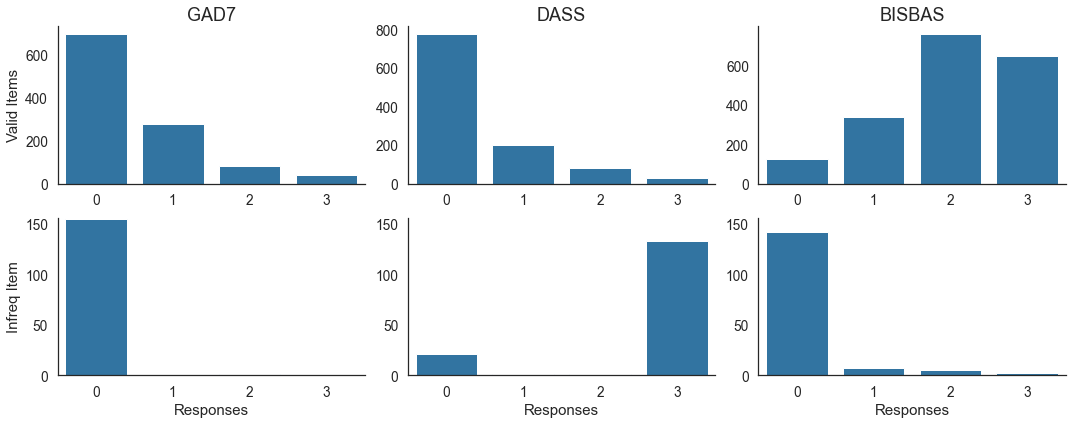

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(2,3,figsize=(15,6))
n_resp = [4,4,4]

## Iteratively plot.
for i, prefix in enumerate(['gad7','dass','bisbas']):
    
    ## Extract responses.
    scale = surveys.filter(regex=f'{prefix}_q').values
    valid = scale[:,:-1].flatten()
    infreq = scale[:,-1]
    
    ## Plot responses.
    sns.countplot(x=valid, order=np.arange(n_resp[i]), color='#1f77b4', ax=axes[0,i])
    sns.countplot(x=infreq, order=np.arange(n_resp[i]), color='#1f77b4', ax=axes[1,i])
    
    ## Add details.
    axes[0,i].set_title(prefix.upper(), fontsize=18)
    axes[1,i].set_xlabel('Responses')
    axes[1,i].set_ylim(0,len(infreq))
    if not i: 
        axes[0,i].set_ylabel('Valid Items')
        axes[1,i].set_ylabel('Infreq Item')
    else:
        axes[0,i].set_ylabel('')
        axes[1,i].set_ylabel('')

sns.despine()
plt.tight_layout()

#### 1.2 Heuristic responding


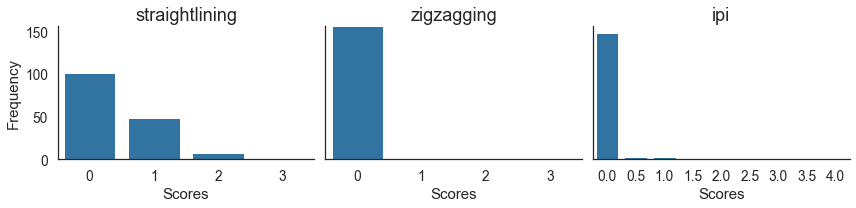

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,3),sharey=True)

## Iteratively plot.
for i, var in enumerate(['straightlining','zigzagging','ipi']):
    
    ## Define order.
    if var == 'ipi': order = np.arange(0,4.1,0.5)
    else: order = np.arange(4)
    
    ## Plot responses.
    sns.countplot(x=surveys[var], order=order, color='#1f77b4', ax=axes[i])
    axes[i].set(xlabel='Scores', ylim=(0,len(surveys)), ylabel='')
    axes[i].set_title(var, fontsize=18)
    if not i: axes[i].set_ylabel('Frequency')
    
sns.despine()
plt.tight_layout()

## Section 2: Task Behavior


In [5]:
## Load data.
data = read_csv(os.path.join('data','data.csv')).query('session==1')

#### 2.1 Choice variability

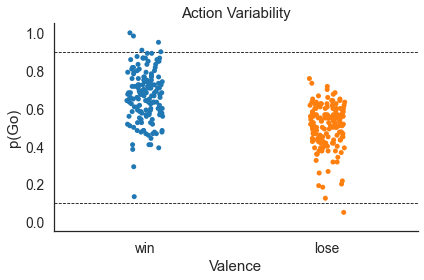

In [6]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Compute choice variability.
gb = data.groupby(['subject','valence']).choice.mean().reset_index()

## Convert to pivot table.
pivot = gb.pivot_table('choice','subject','valence')
pivot = pivot.rename(columns={'win':'variability_win', 'lose':'variability_lose'})

## Merge with reject.
reject = reject.merge(pivot, on='subject', how='outer')

## Plot fraction of trials.
sns.stripplot(x='valence', y='choice', order=['win', 'lose'], data=gb)
ax.axhline(0.1, linestyle='--', lw=0.8, color='k')
ax.axhline(0.9, linestyle='--', lw=0.8, color='k')
ax.set(xlabel='Valence', ylim=(-0.05,1.05), ylabel='p(Go)', title='Action Variability')

sns.despine()
plt.tight_layout()

#### 2.2 Accuracy

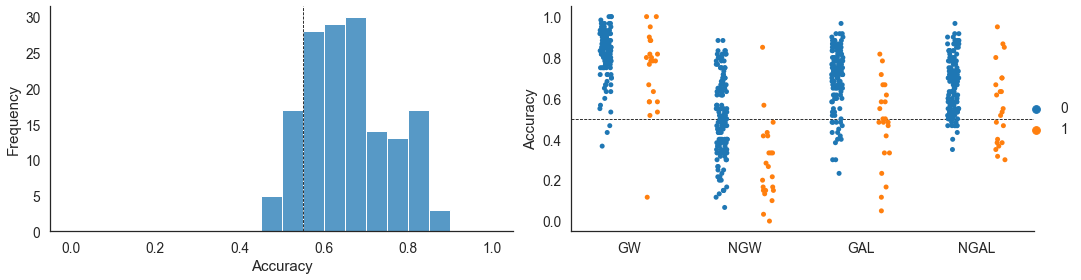

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(15,4))

## Compute overall choice accuracy.
gb = data.groupby('subject').accuracy.mean().reset_index()
reject = reject.merge(gb, on='subject', how='outer')

## Plot overall choice accuracy.
sns.histplot(x='accuracy', data=gb, bins=np.linspace(0,1,21), ax=axes[0])
axes[0].set(xlabel='Accuracy', ylabel='Frequency')
axes[0].axvline(0.55, linestyle='--', lw=0.8, color='k')

## Compute choice accuracy by condition.
gb = data.groupby(['subject','robot']).accuracy.mean().reset_index()
gb = gb.merge(reject[['subject','accuracy']].rename(columns={'accuracy':'reject'}), on='subject', how='outer')
gb.reject = np.where(gb.reject < 0.55, 1, 0)

## Plot choice accuracy by condition.
sns.stripplot(x='robot', y='accuracy', hue='reject', data=gb, order=['GW','NGW','GAL','NGAL'],
              palette=sns.color_palette(n_colors=4), dodge=True, ax=axes[1])
axes[1].set(xlabel='', ylabel='Accuracy')
axes[1].axhline(0.5, linestyle='--', lw=0.8, color='k')
axes[1].legend(loc=7, bbox_to_anchor=(1.1,0.5), frameon=False)

sns.despine()
plt.tight_layout()

## Section 3: Apply rejections

#### 3.1 Apply rejections

In [8]:
## Make new DataFrame.
thresh = reject.copy()

## Apply survey-based rejections.
thresh['infreq']         = np.where(reject['infreq'] >= 1, 1, 0)
thresh['straightlining'] = np.where(reject['straightlining'] > 1, 1, 0)
thresh['zigzagging']     = np.where(reject['zigzagging'] > 0, 1, 0)
thresh['survey']         = thresh[['infreq','zigzagging','straightlining']].sum(axis=1)

## Apply task-based rejections.
thresh['variability_win']  = np.where(reject['variability_win'] > 0.9, 1, 0)
thresh['variability_lose'] = np.where(reject['variability_lose'] < 0.1, 1, 0)
thresh['accuracy']    = np.where(reject['accuracy'] < 0.55, 1, 0)
thresh['task']        = thresh[['variability_win','variability_lose','accuracy']].sum(axis=1)

## Aggregate scores.
thresh['reject'] = thresh[['survey','task']].sum(axis=1)
thresh.to_csv(os.path.join('data','reject.csv'), index=False)

## Print fraction of rejected participants.
print('rejection: %0.3f' %(thresh.reject > 0).mean())
print('sample = %s/%s' %((thresh.reject == 0).sum(), thresh.reject.size))

rejection: 0.295
sample = 110/156


#### 3.2 Return summary of metrics

In [9]:
print('SURVEYS')
print(thresh[['infreq','straightlining','zigzagging']].mean().round(3))

print('\nTASK')
print(thresh[['variability_win','variability_lose','accuracy']].mean().round(3))

SURVEYS
infreq            0.192
straightlining    0.045
zigzagging        0.000
dtype: float64

TASK
variability_win     0.026
variability_lose    0.006
accuracy            0.141
dtype: float64


## Section 4: Retest assignments

In [10]:
np.random.seed(47404)

## Get list of initial character set by subject.
f = lambda x: np.unique(x)[0]
retest = data.groupby('subject').rune_set.apply(f).reset_index()

## Apply rejections.
retest = retest[retest.subject.isin(thresh.query('reject==0').subject)].reset_index(drop=True)
retest = retest.rename(columns={'rune_set':'session_1'})

## Assign character sets for remaining visits.
f = lambda x: np.random.permutation(np.setdiff1d(['elianto','bacs1','bacs2'], x))
retest[['session_2','session_3']] = np.stack(retest.session_1.apply(f))

## Robustness checking.
melt = retest.melt(id_vars='subject', var_name='session', value_name='rune_set')
if not np.all(melt.groupby('subject').rune_set.nunique()==3): raise ValueError('Balancing error.')
    
## Save.
retest.to_csv(os.path.join('data','retest_order.csv'), index=False)